In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

c:\Users\korea\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 LGES2023_CNN으로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES2023_CNN

In [2]:
def plot_representation(X, y, X_syn=None, y_syn=None, method='real'):
    # 정상 데이터, 이상 데이터 추출
    y_normal, y_anomaly = y[y==0].dropna(), y[y==1].dropna()
    X_normal, X_anomaly = X.loc[list(y_normal.index), :], X.loc[list(y_anomaly.index), :]
    
    # Sampling 결과 비교
    # method == 'real': 실제 데이터만 시각화
    # method != 'real': Sampling 결과와 실제 데이터 시각화 비교
    if method.lower() != 'real':
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(1, 2, 1)
    else:
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(1, 1, 1)

    # create_dataset 으로 생성된 데이터 시각화
    # 실제 데이터 사용시 2차원으로 축소 후 본 함수 사용
    # column 명을 정확히 기입해주어야함
    ax1.scatter(X_normal['X1'], X_normal['X2'], alpha=0.3, c='blue', label='Normal')
    ax1.scatter(X_anomaly['X1'], X_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()

    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title('Real', fontsize=20)

    if X_syn is not None:
        ax2 = fig.add_subplot(1, 2, 2)
        y_syn_normal, y_syn_anomaly = y_syn[y_syn==0].dropna(), y_syn[y_syn==1].dropna()
        X_syn_normal, X_syn_anomaly = X_syn.loc[list(y_syn_normal.index), :], X_syn.loc[list(y_syn_anomaly.index), :]

        ax2.scatter(X_syn_normal['X1'], X_syn_normal['X2'], alpha=0.3, c='blue', label='Normal')
        ax2.scatter(X_syn_anomaly['X1'], X_syn_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')

        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.get_xaxis().tick_bottom()
        ax2.get_yaxis().tick_left()

        plt.xlim((-5, 5))
        plt.ylim((-5, 5))
        plt.legend()
        plt.tight_layout()
        plt.title(method, fontsize=20)
        
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    혼동 행렬을 시각화하는 함수입니다.

    인자:
    cm : numpy.ndarray
        혼동 행렬
    classes : list
        클래스 레이블의 이름을 포함하는 리스트
    normalize : bool, optional (default=False)
        True로 설정하면 혼동 행렬을 정규화합니다.
    title : str, optional (default='Confusion Matrix')
        시각화의 제목
    cmap : matplotlib colormap, optional (default=plt.cm.Blues)
        시각화에 사용할 컬러맵

    반환값:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def create_dataset(n_samples=2000,
                weights=(0.8, 0.2),
                n_classes=2,
                n_features=2,
                class_sep=1,
                n_cluster=1,
                random_state=0):
    df = make_classification(n_samples=n_samples, n_features=n_features,
                            n_informative=n_features, n_redundant=0, n_repeated=0,
                            n_classes=n_classes,
                            n_clusters_per_class=n_cluster,
                            weights=list(weights),
                            class_sep=class_sep, random_state=random_state)
    
    X = pd.DataFrame(df[0], columns=[f'X{i}' for i in range(1, n_features+1)])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

def calculate_classification_metrics(true_labels, predicted_labels):
    """
    true값과 pred값을 입력받아 accuracy, precision, recall, micro F1-score, macro F1-score를 계산하고 출력하는 함수입니다.

    인자:
    true_labels : array-like of shape (n_samples,)
        실제 레이블
    predicted_labels : array-like of shape (n_samples,)
        예측된 레이블
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

## Generative Adversarial Networks(GAN)

소수 클래스에 대해 생성모델을 만들고 생성모델을 통해서 oversampling

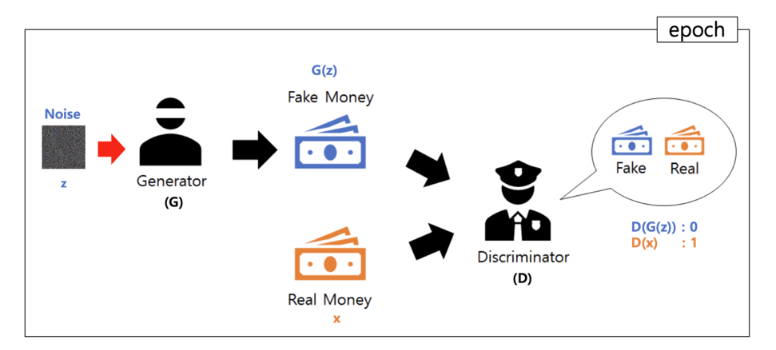

In [3]:
Image.open('./imgs/img10.png')

In [4]:
X_syn, y_syn = create_dataset(n_samples=5000,
                              weights=(0.9, 0.1), 
                              n_cluster=1, 
                              n_features=256, 
                              random_state=711)

In [5]:
X_syn.shape, y_syn.shape

((5000, 256), (5000, 1))

In [6]:
y_syn.value_counts()

y
0    4483
1     517
dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, random_state=2023)

### Baseline

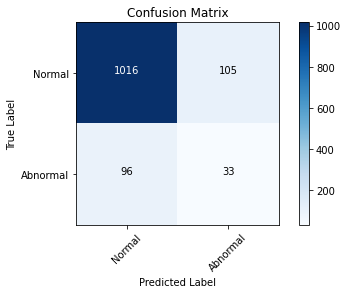

Accuracy : 0.8392
Precision : 0.5764
Recall : 0.5811
F1-score : 0.5786


In [8]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
dt_tree.fit(X_train, y_train)

y_pred_test = dt_tree.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

## Make Dataset & DataLoader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X):
        super().__init__()
        
        self.X = X.to_numpy()
        
    def __getitem__(self, index):
        X = torch.FloatTensor(self.X[index])
        return X
    
    def __len__(self):
        return len(self.X)

In [10]:
X_mino = X_train[y_train.squeeze(1)==1]
X_mino.shape

(388, 256)

In [11]:
mino_datasets = CustomDataset(X_mino)
dataloader = DataLoader(mino_datasets,
                        batch_size=64, 
                        sampler=torch.utils.data.RandomSampler(mino_datasets),
                        drop_last=True)

## Model 구축 (Generator & Discriminator)

In [12]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = F.leaky_relu(self.fc3(x), 0.1)
        return torch.tanh(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)

        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)

        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(x)

In [31]:
# model hyperparameter-Generator
g_input_dim = 100
g_hidden_dim = 128
g_output_dim = 256 # number of features of X

# model hyperparameter-Discriminator
d_input_dim = g_output_dim
d_hidden_dim = 128

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# build model
G = Generator(g_input_dim, g_hidden_dim, g_output_dim)
G = G.to(device=device)
D = Discriminator(d_input_dim, d_hidden_dim)
D = D.to(device=device)

## GAN Training

In [33]:
# 목적함수 설정
criterion = nn.BCELoss()
criterion = criterion.to(device=device)

# Optimizer 설정
optimizer_g = optim.Adam(G.parameters(), lr=0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)

In [34]:
# Training
from tqdm import tqdm

epochs = 100
total_step = len(dataloader)
g_losses, d_losses = [], []
D.train()
G.train()
for epoch in range(epochs):
    with tqdm(total=len(dataloader)) as tbar:
        for idx, X in enumerate(dataloader):
            N, _ = X.size()

            X = X.to(device=device)

            # make labels
            label_real = torch.ones(size=(N,1)).to(device=device)
            label_fake = torch.zeros(size=(N,1)).to(device=device)
            
            # training discriminator
            optimizer_d.zero_grad()
            output_real = D(X)

            d_loss_real = criterion(output_real, label_real)
            score_real = output_real

            z = torch.randn(N, g_input_dim).to(device=device)
            fake_imgs = G(z) # Images from Generator
            output_fake = D(fake_imgs)
            d_loss_fake = criterion(output_fake, label_fake)
            score_fake = output_fake

            # backpropagation
            d_loss_total = d_loss_fake+d_loss_real  
            d_loss_total.backward()
            optimizer_d.step()
            
            d_losses.append(d_loss_total.item())
            
            # training generator
            optimizer_g.zero_grad()
            z = torch.randn(N, g_input_dim).to(device=device)
            fake_imgs = G(z)

            output_fake = D(fake_imgs)

            g_loss = criterion(output_fake, label_real)

            g_loss.backward()
            optimizer_g.step()

            g_losses.append(g_loss.item())

            tbar.set_description('Epoch [{:3d}/{:3d}], Step [{:2d}/{:2d}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, epochs, idx + 1, total_step, d_loss_total.item(), g_loss.item(),
                          score_real.mean().item(), score_fake.mean().item()))

            tbar.update(1)

Epoch [  1/100], Step [ 6/ 6], d_loss: 1.1247, g_loss: 0.6407, D(x): 0.72, D(G(z)): 0.53: 100%|██████████| 6/6 [00:00<00:00, 32.60it/s]
Epoch [  2/100], Step [ 6/ 6], d_loss: 1.0899, g_loss: 0.6383, D(x): 0.75, D(G(z)): 0.53: 100%|██████████| 6/6 [00:00<00:00, 187.51it/s]
Epoch [  3/100], Step [ 6/ 6], d_loss: 1.0256, g_loss: 0.6365, D(x): 0.80, D(G(z)): 0.53: 100%|██████████| 6/6 [00:00<00:00, 162.17it/s]
Epoch [  4/100], Step [ 6/ 6], d_loss: 0.9223, g_loss: 0.6369, D(x): 0.88, D(G(z)): 0.53: 100%|██████████| 6/6 [00:00<00:00, 193.55it/s]
Epoch [  5/100], Step [ 6/ 6], d_loss: 0.9798, g_loss: 0.6304, D(x): 0.85, D(G(z)): 0.54: 100%|██████████| 6/6 [00:00<00:00, 175.80it/s]
Epoch [  6/100], Step [ 6/ 6], d_loss: 0.8997, g_loss: 0.6196, D(x): 0.90, D(G(z)): 0.53: 100%|██████████| 6/6 [00:00<00:00, 199.98it/s]
Epoch [  7/100], Step [ 6/ 6], d_loss: 0.9430, g_loss: 0.6329, D(x): 0.88, D(G(z)): 0.54: 100%|██████████| 6/6 [00:00<00:00, 200.28it/s]
Epoch [  8/100], Step [ 6/ 6], d_loss: 0.9

<AxesSubplot:>

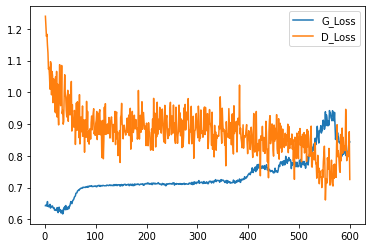

In [35]:
import seaborn as sns

sns.lineplot(x=range(1,len(g_losses)+1),y=g_losses, label='G_Loss')
sns.lineplot(x=range(1,len(d_losses)+1),y=d_losses, label='D_Loss')

## Sampling from Generator

In [46]:
n_sampling = 2000
G.eval()
with torch.no_grad():
    z = torch.randn(n_sampling, g_input_dim).to(device=device)

    X_gan = G(z)
X_gan = X_gan.cpu().numpy()
y_gan = np.ones(shape=(len(X_gan),1))

In [47]:
X_resampled = np.concatenate([X_train, X_gan], axis=0)
y_resampled = np.concatenate([y_train, y_gan], axis=0)

print(f'X shape : {X_train.shape} | After Sampling : {X_resampled.shape}')

X shape : (3750, 256) | After Sampling : (5750, 256)


c:\Users\korea\anaconda3\envs\py39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


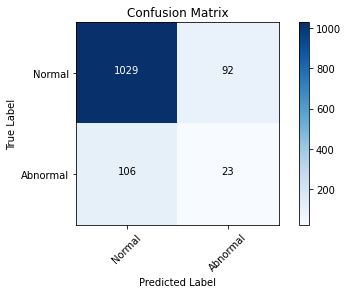

Accuracy : 0.8416
Precision : 0.5533
Recall : 0.5481
F1-score : 0.5504


In [48]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
dt_tree.fit(X_resampled, y_resampled)

y_pred_test = dt_tree.predict(X_test)
cm_gan = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_gan, classes)
_, _, _, f1_gan = calculate_classification_metrics(y_test, y_pred_test)

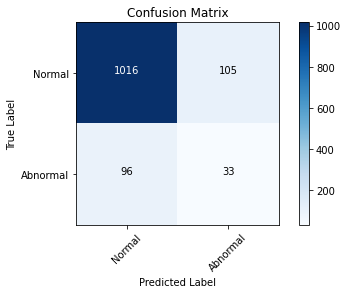

In [49]:
plot_confusion_matrix(cm_baseline, classes)